## Load packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

## Load data

In [2]:
# Load matrices from CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

subjectsWithoutShift = np.arange(len(ISC_EEG))

# Remove Inf in data for EDA and IBI (try to have similar ratio as in EEG between diagonal and mean non-diagonal)
tmp_EEG = np.copy(ISC_EEG)
tmp_EDA = np.copy(ISC_EDA)
tmp_IBI = np.copy(ISC_IBI)

for i in range(len(tmp_EEG)):
    tmp_EEG[i,i] = 0
    tmp_EDA[i,i] = 0
    tmp_IBI[i,i] = 0
eegNorm = 3/np.mean(tmp_EEG)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(tmp_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(tmp_EDA)*eegNorm
    
subjects = np.arange(len(ISC_EEG))

## Parameters

In [3]:
case = 'EEG'

In [4]:
# Choose study matrix according to case study
if (case == 'EEG'):
    study_matrix = ISC_EEG
elif (case == 'EDA'):
    study_matrix = ISC_EDA
elif (case == 'IBI'):
    study_matrix = ISC_IBI

## Compute distance matrix

In [5]:
def computeDistanceMatrix(study_matrix=study_matrix):
    
    # Normalise maximum value to 1
    matrix_norm = np.copy(study_matrix)
    matrix_norm = matrix_norm / np.max(abs(matrix_norm))

    # Convert into distance matrix
    distance_matrix = np.sqrt((1-matrix_norm)) # Formula in Matlab and in Scikit to convert 
    
    # Interval MDS normalization
    a = np.min(np.sort(distance_matrix,axis=0)[1,:])
    distance_matrix = distance_matrix - a
    distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))
    
    # To make sure output is perfectly symmetrical
    return (distance_matrix+distance_matrix.T)/2

## Plot points

In [6]:
from sklearn.decomposition import PCA

# Show MDS scaling
import matplotlib.patches as mpatches

def plotPoints(points,projection=False,title='Ground truth',subjects=subjects,subjectsWithoutShift=subjectsWithoutShift):
    
    condition = trueGroups(removeOutlier)  
    condition = condition[subjectsWithoutShift]
    subjects=np.arange(len(condition))
    NA = np.where(condition[subjects]==0)[0]
    SSA = np.where(condition[subjects]==1)[0]

    if (points.shape[1] != 1):
        ax = plt.axes([1.2,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        if (projection):
            points = transformPoints(points)

        for i in range(len(points)):
            ax.annotate(subjectsWithoutShift[i],(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))

        plt.scatter(points[NA,0],points[NA,1],color='blue',s=145,label='NA')
        plt.scatter(points[SSA,0],points[SSA,1],color='red',s=145,label='SSA')
    else:
        plt.scatter(points[NA],np.zeros((len(NA),1)),marker='x',color='blue')
        plt.scatter(points[SSA],np.zeros((len(SSA),1)),marker='x',color='red')
        orderedSubjectPlot = np.argsort(points.T)
        for i in range(len(points)):
            subj = orderedSubjectPlot[0,i]
            plt.annotate(subj,(points[subj,0],0),xytext=(points[subj,0]-((i+1)%2+1)*np.max(points)/35,0.01*(i%2)-0.0065))
        
    NA = mpatches.Patch(color='blue', label='NA')
    SSA = mpatches.Patch(color='red', label='SSA')
    plt.legend(handles=[NA,SSA])
    
    plt.title(title)
    
# Shepard diagram
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import euclidean_distances

def shepardDiagram(distance_matrix,points,disparities,title=''):
    ax = plt.axes([0,0,1.2,1.2])
    #ax.set_aspect(aspect='equal')
    
    order = np.lexsort((np.ravel(distance_matrix),np.ravel(disparities)))

    computedDistances = pdist(points);
    computedDistances = squareform(computedDistances);
    computedDistances = euclidean_distances(points)

    plt.scatter(np.ravel(distance_matrix),np.ravel(computedDistances))
    plt.plot(np.ravel(distance_matrix)[order],np.ravel(disparities)[order],'r.')
    plt.xlabel('Dissimilarities')
    plt.ylabel('Distances/Disparities')
    plt.title(title)
    corr = np.corrcoef(np.ravel(computedDistances),np.ravel(disparities))
    return corr[1,0]

## PCoA

In [7]:
from skbio.stats.ordination import pcoa

def computePCoACoordinate(distance_matrix,n_comp=2):
    
    pcoa_map = pcoa(distance_matrix, method='eigh', number_of_dimensions=n_comp)
    points = np.array(pcoa_map.samples)
    return points

## Multiview mapping

In [8]:
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array
ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array
ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array
subjectsWithoutShift = np.arange(len(ISC_EEG))

# Remove Inf in data for EDA and IBI (replace by sort of normalisation for the moment)
tmp_EEG = np.copy(ISC_EEG)
tmp_EDA = np.copy(ISC_EDA)
tmp_IBI = np.copy(ISC_IBI)

for i in range(len(tmp_EEG)):
    tmp_EEG[i,i] = 0
    tmp_EDA[i,i] = 0
    tmp_IBI[i,i] = 0
eegNorm = 3/np.mean(tmp_EEG)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(tmp_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(tmp_EDA)*eegNorm

study_matrix = ISC_EEG
N = len(study_matrix)
subjects = np.arange(N)

In [9]:
def computeAllDistanceMatrix():
    
    # Copy correlation matrices
    mat_EEG = np.copy(ISC_EEG)
    mat_EDA = np.copy(ISC_EDA)
    mat_IBI = np.copy(ISC_IBI)

    # Compute 3 distance matrices (according to each modality)
    distance_matrix_EEG = computeDistanceMatrix(mat_EEG)
    distance_matrix_EDA = computeDistanceMatrix(mat_EDA)
    distance_matrix_IBI = computeDistanceMatrix(mat_IBI)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(mat_EEG)):
        mat_EEG[i,i] = 0
        mat_EDA[i,i] = 0
        mat_IBI[i,i] = 0
    distance_matrix_corr_EEG = pairwise_distances(mat_EEG,metric='correlation')
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')
    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')

    # Return distance matrices
    return distance_matrix_EEG, distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EEG, distance_matrix_corr_EDA, distance_matrix_corr_IBI

In [10]:
from multiview.mvmds import mvmds
def computeMVMDSCoordinate(mat=['EEG','EDA','IBI','corrEEG','corrEDA','corrIBI']):

    # Computing all distance matrices
    distance_matrix_EEG, distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EEG, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix()    

    # Choosing which matrices to include into the multiview
    multiviewMat = []
    if ('EEG' in mat):
        multiviewMat.append(distance_matrix_EEG)
    if ('EDA' in mat):
        multiviewMat.append(distance_matrix_EDA)
    if ('IBI' in mat):
        multiviewMat.append(distance_matrix_IBI)
    if ('corrEEG' in mat):
        multiviewMat.append(distance_matrix_corr_EEG)
    if ('corrEDA' in mat):
        multiviewMat.append(distance_matrix_corr_EDA)
    if ('corrIBI' in mat):
        multiviewMat.append(distance_matrix_corr_IBI)
        
    # Computing multiview mapping
    points = mvmds(multiviewMat,len(mat)*[True],2)
    return points

## Compute clustering

In [11]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

import warnings
from pyclustertend import hopkins
from sklearn.metrics import pairwise_distances

class Results():

    def __init__(self,name,mat=[case]):
        self.accuracy = 0
        self.label = np.zeros(N)
        self.name = name
        self.best_points = None
        self.SC = -1
        self.mat = mat
        
    def shepardDiagram(self):
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        #ax.set_aspect(aspect='equal')

        disparities = self.distance_matrix
        order = np.lexsort((np.ravel(self.distance_matrix),np.ravel(disparities)))

        computedDistances = pdist(self.best_points);
        computedDistances = squareform(computedDistances);
        computedDistances = euclidean_distances(self.best_points)

        plt.scatter(np.ravel(self.distance_matrix),np.ravel(computedDistances))
        plt.plot(np.ravel(self.distance_matrix)[order],np.ravel(disparities)[order],'r.')
        plt.xlabel('Dissimilarities')
        plt.ylabel('Distances/Disparities')
        plt.title('')
        corr = np.corrcoef(np.ravel(computedDistances),np.ravel(disparities))
        return corr[1,0]
        
    def twoClustersMethodResult(self):
        print("Results\n")
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        print("Found clusters ")
        print(self.label)
        print("Silhouette coefficient : %0.3f" %self.SC)
        
    def applyMethod(self,method):
        self.distance_matrix = computeDistanceMatrix(study_matrix=study_matrix)

        points = computeMVMDSCoordinate(self.mat)

        meth = method.fit(points)

        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)

        self.label = label
        self.best_points = points
        self.SC = self.silhouetteCoef()
         
    def showResultMap(self):
        plt.figure()

        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        for i in range(len(subjects)):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))
            
        ax.scatter(self.best_points[self.label==0,0],self.best_points[self.label==0,1],color='darkgreen',s=145)
        ax.scatter(self.best_points[self.label==1,0],self.best_points[self.label==1,1],color='darkorange',s=145)

        group0 = mpatches.Patch(color='darkgreen', label='First group')
        group1 = mpatches.Patch(color='darkorange', label='Second group')
        plt.legend(handles=[group0,group1])
        
        plt.title("%s clustering" %self.name)
        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        for p in range(100):
            H.append(hopkins(self.best_points,len(subjects)))   
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    # Compute Silhouette Coefficient based on distance matrix(small means good clustering)
    def silhouetteCoef(self):
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(subjects):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')

[[0.01378513 0.        ]
 [0.         0.01225416]]
Results

Hopkins test
0.554950 +- 0.033441
Found clusters 
[0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0]
Silhouette coefficient : 0.409
DB index : 0.967638 


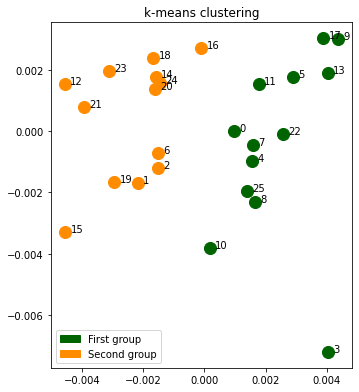

In [12]:
from sklearn.cluster import KMeans

mat = ['EEG','EDA','IBI']
#mat = ['EDA','IBI']
mat = ['EEG']
kmeans_result = Results("k-means",mat=mat)
kmeans = KMeans(n_clusters=2,n_init=100)
kmeans_result.applyMethod(kmeans)

kmeans_result.twoClustersMethodResult()
kmeans_result.showResultMap()
print("DB index : %f " %kmeans_result.dbScore())